<a href="https://colab.research.google.com/github/leonardopazo/MLPos/blob/main/MVP_CLASSIFICA%C3%87%C3%83O_FILMES_IMDB_LEONARDO_PAZO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **Descrição do problema:**

O objetivo é prever a classificação dos filmes (binned IMDb score) com base em características como duração, orçamento, popularidade dos atores e outros atributos do dataset movie_metadata.csv.

- **Premissas ou hipóteses:**

Filmes com orçamentos maiores ou diretores renomados tendem a receber notas mais altas.
Certos gêneros e classificações indicativas impactam as avaliações.
Filmes mais curtos ou longos podem ter diferentes impactos dependendo do público-alvo.

- **Restriçoes ou condições:**

Colunas com muitos valores ausentes ou dados categóricos irrelevantes foram descartadas.
Valores ausentes importantes foram preenchidos com medianas ou valores padrão (e.g., orçamento e receita).
Linhas duplicadas foram removidas.

- **Descrição do dataset:**
O dataset contém atributos como:

Variáveis contínuas: duração (duration), orçamento (budget), receita (gross), likes em redes sociais (movie_facebook_likes).
Variáveis categóricas: classificação indicativa (content_rating), ano (title_year), entre outras.
A variável alvo é imdb_binned_score, categorizada em 4 níveis de qualidade.


## **1. Instalações e imports**
Instalações e imports das bibliotecas utilizadas em todo o código.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import itertools

## **2. Carregamento e visualização dos dados**
Fazendo Upload dos dados e salvando em uma variável chamada 'df'


In [28]:
def load_file(filepath):
    return pd.read_csv(filepath, sep=',')

# Carregando os datasets
df = load_file('https://raw.githubusercontent.com/leonardopazo/MLPos/refs/heads/main/movie_metadata.csv')


In [29]:
# Visualizando as primeiras 5 linhas do dataframe
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [30]:
# Mostra o número de linhas e colunas do dataframe
df.shape

(5043, 28)

In [31]:
# Mostra o tipo de dado de cada coluna
df.dtypes

,0
color,object
director_name,object
num_critic_for_reviews,float64
duration,float64
director_facebook_likes,float64
actor_3_facebook_likes,float64
actor_2_name,object
actor_1_facebook_likes,float64
gross,float64
genres,object


- **Preparação dos Dados**

1. Separe o dataset entre treino e teste (e validação, se aplicável):

O dataset foi dividido em 70% para treino e 30% para teste.

2. Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.

Não foi utilizado, pois o modelo inicial (regressão logística) é simples e a divisão treino-teste é suficiente para avaliar o desempenho inicial. Em cenários mais complexos ou com menos dados, a validação cruzada seria recomendada.

3. Verifique quais operações de transformação de dados são mais apropriadas:

Dados contínuos foram padronizados com StandardScaler.
Variáveis categóricas foram convertidas em variáveis dummy (get_dummies), excluindo uma categoria para evitar multicolinearidade.

4. Refine a quantidade de atributos disponíveis (feature selection):

Variáveis com alta correlação foram combinadas (e.g., soma de likes de atores).
Variáveis irrelevantes ou redundantes, como nomes de diretores/atores e gêneros, foram removidas.

In [32]:
# Descartando a coluna com o link do IMDB do filme
df.drop('movie_imdb_link', axis=1, inplace=True)

# Descartando a coluna 'color'
df.drop('color', axis=1, inplace=True)

In [33]:
df.isna().sum()

,0
director_name,104
num_critic_for_reviews,50
duration,15
director_facebook_likes,104
actor_3_facebook_likes,23
actor_2_name,13
actor_1_facebook_likes,7
gross,884
genres,0
actor_1_name,7


In [34]:
# Descartando as linhas que tem poucos valores faltantes
df.dropna(axis=0, subset=['director_name', 'num_critic_for_reviews',
                               'duration','director_facebook_likes','actor_3_facebook_likes',
                               'actor_2_name','actor_1_facebook_likes','actor_1_name','actor_3_name',
                               'facenumber_in_poster','num_user_for_reviews','language','country',
                               'actor_2_facebook_likes','plot_keywords', 'title_year'],inplace=True)

In [35]:
# Verificando quantas linhas de dados ainda estão no dataframe. Perdemos apenas 6% dos dados
df.shape

(4735, 26)

In [36]:
# Verificando quais os valores na coluna 'content rating' (classificação indicativa)
df['content_rating'].value_counts()

,count
content_rating,
R,2081
PG-13,1435
PG,681
G,109
Not Rated,100
Unrated,58
Approved,55
X,13
Passed,9


In [37]:
# Substituindo os valores faltantes por 'R' que sao os com conteudo livre
df.fillna({'content_rating': 'R'}, inplace=True)

In [38]:
# Verificando quais os valores na coluna 'aspect ratio' (proporção de tela)
df['aspect_ratio'].value_counts()

,count
aspect_ratio,
2.35,2309
1.85,1884
1.37,97
1.78,80
1.66,63
1.33,34
2.20,15
2.39,14
16.00,8


In [39]:
# Substituindo os valores faltantes pela mediana dos valores
df.fillna({'aspect_ratio': df['aspect_ratio'].median()}, inplace=True)

df.fillna({'budget': df['budget'].median()}, inplace=True)

df.fillna({'gross': df['gross'].median()}, inplace=True)

In [40]:
# Verificando se removemos (ou substituimos) todos os valores faltantes
df.isna().sum()

,0
director_name,0
num_critic_for_reviews,0
duration,0
director_facebook_likes,0
actor_3_facebook_likes,0
actor_2_name,0
actor_1_facebook_likes,0
gross,0
genres,0
actor_1_name,0


In [41]:
# Verificando se temos valores duplicados
df.duplicated().sum()

42

In [42]:
# Removendo as duplicatas
df.drop_duplicates(inplace=True)

In [43]:
df.shape

(4693, 26)

In [44]:
# Verificando os valores na coluna 'language' percebemos que tem uma distribuição muito desbalanceada
df['language'].value_counts()

,count
language,
English,4405
French,69
Spanish,35
Hindi,25
Mandarin,24
German,18
Japanese,16
Russian,11
Italian,10


In [45]:
# Excluindo a coluna de 'language'
df.drop('language',axis=1, inplace=True)

In [46]:
# Verificando os valores na coluna 'language' percebemos que tem uma distribuição muito desbalanceada
df['country'].value_counts()

,count
country,
USA,3567
UK,420
France,149
Canada,106
Germany,96
Australia,53
Spain,32
India,27
China,24


In [47]:
# Excluindo a coluna de 'language'
df.drop('country',axis=1, inplace=True)

In [48]:
df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,facenumber_in_poster,plot_keywords,num_user_for_reviews,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,0.0,avatar|future|marine|native|paraplegic,3054.0,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,0.0,goddess|marriage ceremony|marriage proposal|pi...,1238.0,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,1.0,bomb|espionage|sequel|spy|terrorist,994.0,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,0.0,deception|imprisonment|lawlessness|police offi...,2701.0,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,...,1.0,alien|american civil war|male nipple|mars|prin...,738.0,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000


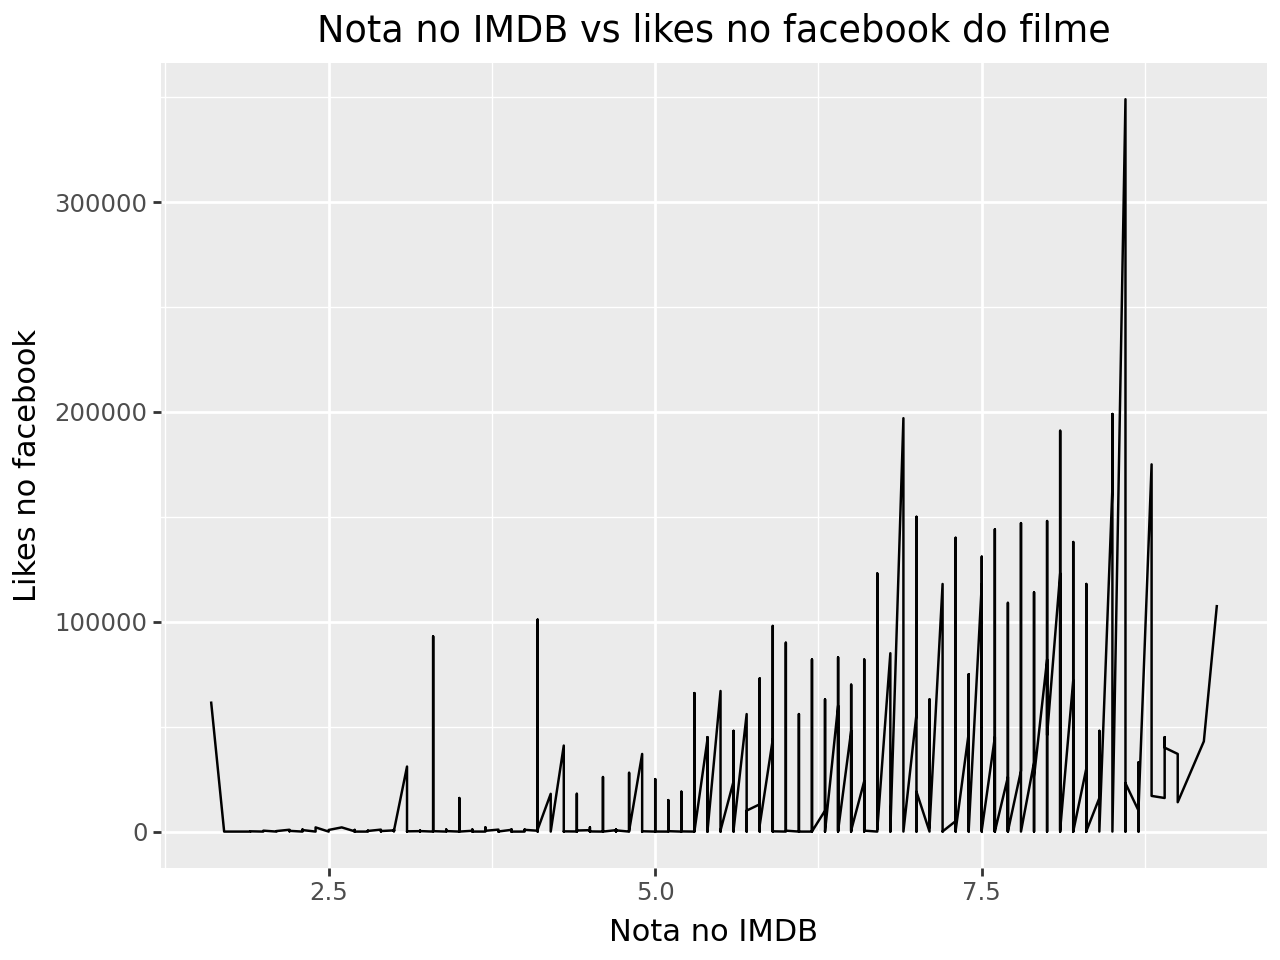

In [49]:
(ggplot(df)+\
    aes(x='imdb_score', y='movie_facebook_likes') +\
    geom_line() +\
    labs(title='Nota no IMDB vs likes no facebook do filme', x='Nota no IMDB', y='Likes no facebook')
)


<ipython-input-50-33f964b71bdf>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


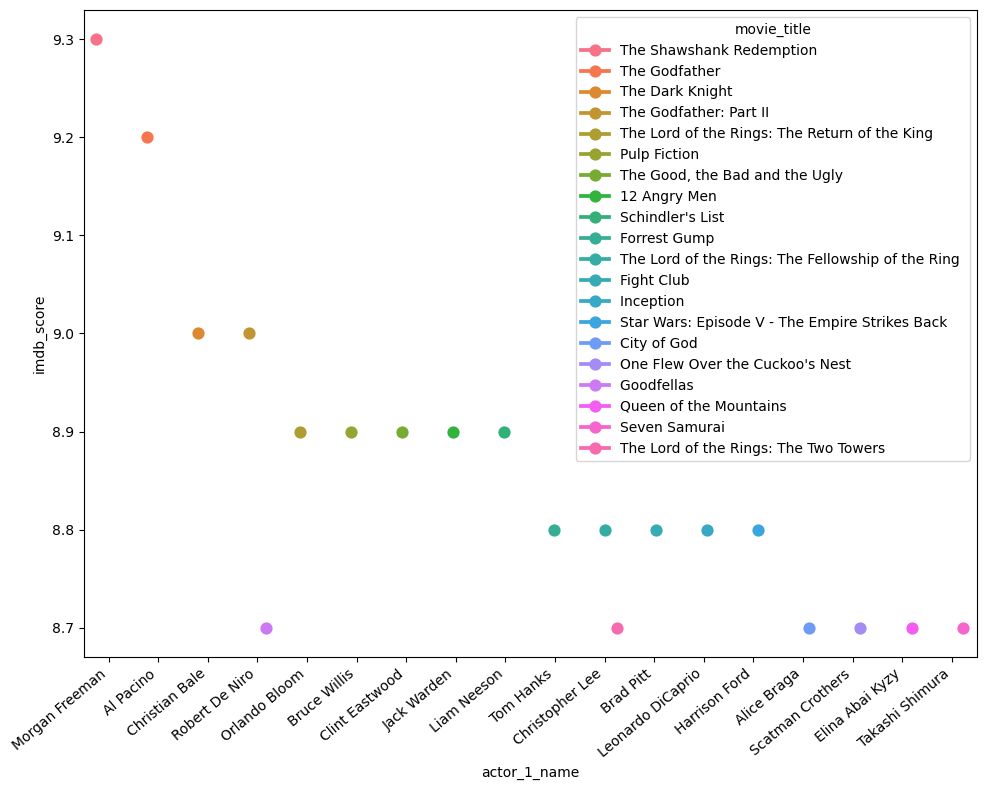

In [50]:
# Ordena o dataframe com base na nota IMDB e seleciona os 20 melhores filmes
df_sorted = df.sort_values(by='imdb_score', ascending=False).head(20)

# Cria o gráfico
plt.figure(figsize=(10, 8))
ax = sns.pointplot(x='actor_1_name', y='imdb_score', data=df_sorted, hue='movie_title', dodge=True, markers='o')

# Rotaciona os rótulos do eixo X para uma melhor visualização
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Ajuste de layout
plt.tight_layout()
plt.show()

In [51]:
#retirando algumas colunas com dados categóricos nao necessarios
df.drop(columns=['director_name', 'actor_1_name', 'actor_2_name',
                 'actor_3_name', 'plot_keywords', 'movie_title'], axis=1, inplace=True)

In [52]:
#verificando os valores da coluna 'genre'
df['genres'].value_counts()

,count
genres,
Drama,209
Comedy,186
Comedy|Drama|Romance,182
Comedy|Drama,180
Comedy|Romance,149
...,...
Adventure|Comedy|Family|Sci-Fi,1
Action|Adventure|Crime|Drama|Family|Fantasy|Romance|Thriller,1
Adventure|Comedy|History|Romance,1


In [53]:
#retirando a coluna 'genres'
df.drop('genres', axis=1, inplace=True)


In [54]:
list[df.columns]

list[Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes'],
      dtype='object')]

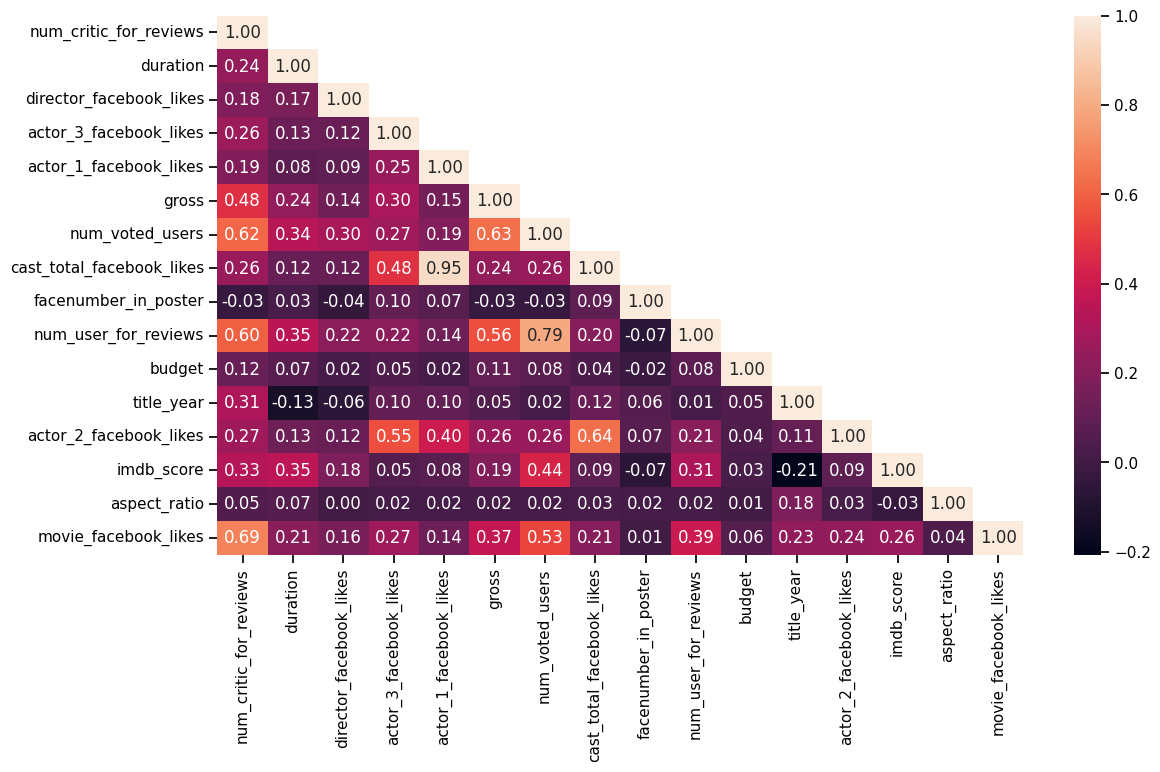

In [55]:
# Selecionando apenas as colunas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Calculando a matriz de correlação
corr = df_numeric.corr()

# Configurando o contexto do gráfico
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})

# Criando o gráfico de mapa de calor
plt.figure(figsize=(13, 7))

# Máscara para ocultar a metade superior da matriz
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

# Gerando o heatmap
a = sns.heatmap(corr, mask=mask, annot=True, fmt='.2f')


In [56]:
# Criando novas colunas combinando as colunas muito correlacionadas
df['Other_actors_facebook_likes'] = df['actor_2_facebook_likes'] + df['actor_3_facebook_likes']

df['critic_review_ratio'] = df['num_critic_for_reviews']/df['num_user_for_reviews']

In [57]:
#removendo as colunas
df.drop(columns=['actor_2_facebook_likes', 'actor_3_facebook_likes',
                 'cast_total_facebook_likes'], axis=1, inplace=True)

In [58]:
#removendo as colunas
df.drop(columns=['num_critic_for_reviews', 'num_user_for_reviews'], axis=1, inplace=True)

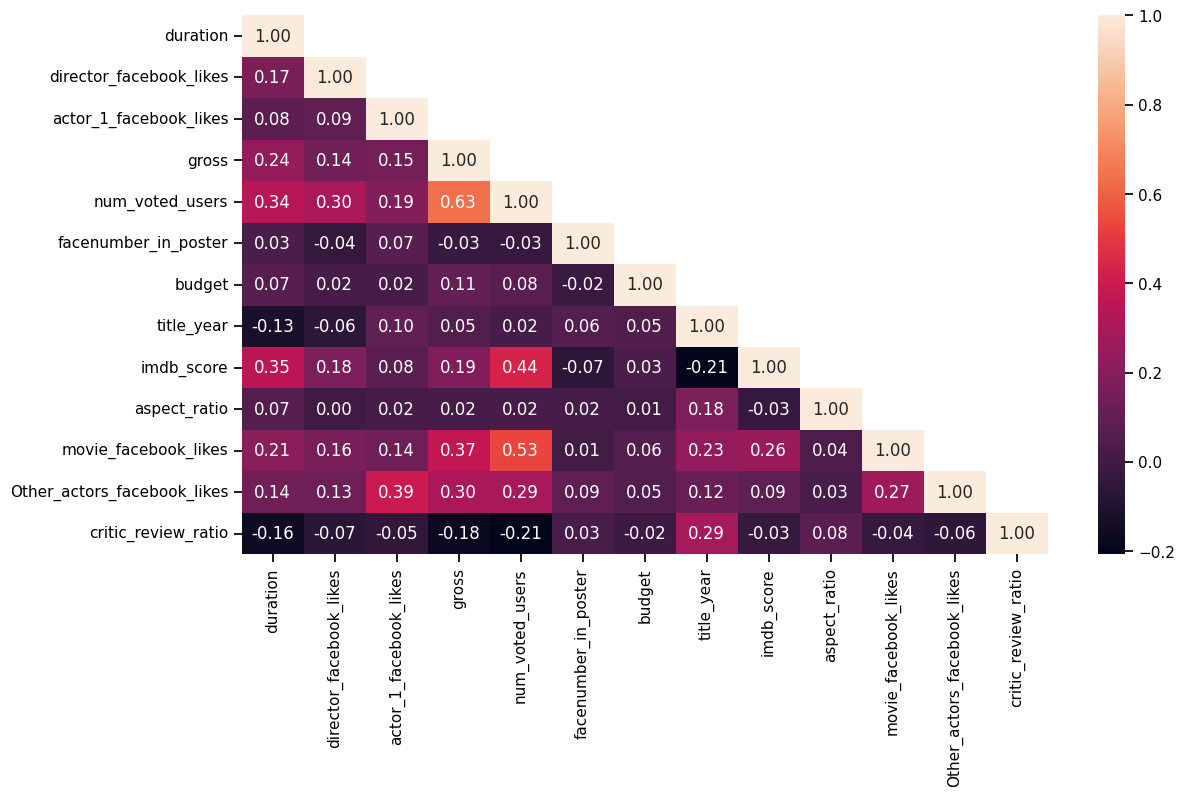

In [59]:
#verificando se ainda existem colunas fortemente correlacionadas

# Selecionando apenas as colunas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Calculando a matriz de correlação
corr = df_numeric.corr()

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(13,7))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True

a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')

In [60]:
#categorizando os valores de nota do imdb
df['imdb_binned_score']=pd.cut(df['imdb_score'], bins=[0,4,6,8,10], right=True, labels=False)+1

In [61]:
df.head()

,duration,director_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,facenumber_in_poster,content_rating,budget,title_year,imdb_score,aspect_ratio,movie_facebook_likes,Other_actors_facebook_likes,critic_review_ratio,imdb_binned_score
0,178.0,0.0,1000.0,760505847.0,886204,0.0,PG-13,237000000.0,2009.0,7.9,1.78,33000,1791.0,0.236739,3
1,169.0,563.0,40000.0,309404152.0,471220,0.0,PG-13,300000000.0,2007.0,7.1,2.35,0,6000.0,0.243942,3
2,148.0,0.0,11000.0,200074175.0,275868,1.0,PG-13,245000000.0,2015.0,6.8,2.35,85000,554.0,0.605634,3
3,164.0,22000.0,27000.0,448130642.0,1144337,0.0,PG-13,250000000.0,2012.0,8.5,2.35,164000,46000.0,0.301000,4
5,132.0,475.0,640.0,73058679.0,212204,1.0,PG-13,263700000.0,2012.0,6.6,2.35,24000,1162.0,0.626016,3


In [62]:
# Criando novas colunas para transformar os valores categóricos de 'content rating' (classificação indicativa) em valores numéricos
df = pd.get_dummies(data = df, columns=['content_rating'], prefix=['content_rating'], drop_first=True)

In [63]:
df.head()

,duration,director_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,facenumber_in_poster,budget,title_year,imdb_score,aspect_ratio,...,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_TV-14,content_rating_TV-G,content_rating_TV-PG,content_rating_Unrated,content_rating_X
0,178.0,0.0,1000.0,760505847.0,886204,0.0,237000000.0,2009.0,7.9,1.78,...,False,False,True,False,False,False,False,False,False,False
1,169.0,563.0,40000.0,309404152.0,471220,0.0,300000000.0,2007.0,7.1,2.35,...,False,False,True,False,False,False,False,False,False,False
2,148.0,0.0,11000.0,200074175.0,275868,1.0,245000000.0,2015.0,6.8,2.35,...,False,False,True,False,False,False,False,False,False,False
3,164.0,22000.0,27000.0,448130642.0,1144337,0.0,250000000.0,2012.0,8.5,2.35,...,False,False,True,False,False,False,False,False,False,False
5,132.0,475.0,640.0,73058679.0,212204,1.0,263700000.0,2012.0,6.6,2.35,...,False,False,True,False,False,False,False,False,False,False


In [64]:
# Escolhendo as colunas do dataframe que serão nossos valores de entrada para o modelo
X=pd.DataFrame(columns=['duration','director_facebook_likes','actor_1_facebook_likes','gross',
                        'num_voted_users','facenumber_in_poster','budget','title_year','aspect_ratio',
                        'movie_facebook_likes','Other_actors_facebook_likes','critic_review_ratio',
                        'content_rating_G','content_rating_GP',
                        'content_rating_M','content_rating_NC-17','content_rating_Not Rated',
                        'content_rating_PG','content_rating_PG-13','content_rating_Passed',
                        'content_rating_R','content_rating_TV-14','content_rating_TV-G',
                        'content_rating_TV-PG','content_rating_Unrated','content_rating_X'],data=df)

In [65]:
#escolhendo a(s) coluna(s) do dataframe que serão a variavel target do modelo
y = pd.DataFrame(columns=['imdb_binned_score'], data=df)

In [66]:
#dividindo os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [67]:
# Normalizando os dados
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [68]:
X.isna().sum()

,0
duration,0
director_facebook_likes,0
actor_1_facebook_likes,0
gross,0
num_voted_users,0
facenumber_in_poster,0
budget,0
title_year,0
aspect_ratio,0
movie_facebook_likes,0


- **Modelagem e Treinamento**

1. Selecione os algoritmos mais indicados:
Foi usada a regressão logística devido à natureza do problema de classificação e à simplicidade do modelo inicial.

2. Há algum ajuste inicial para os hiperparâmetros?
Sim, o parâmetro max_iter foi ajustado para 1000 para garantir a convergência do modelo. O ajuste de regularização (C) pode ser explorado em iterações futuras.

3. O modelo foi devidamente treinado? Foi observado problema de underfitting?
O modelo foi treinado com bons resultados para as classes mais representativas (classes 2 e 3). Não houve sinais claros de underfitting, mas a classe 1 apresenta baixo desempenho devido a desequilíbrio no dataset.

4. É possível otimizar os hiperparâmetros?
Sim, otimização do hiperparâmetro C ou uso de regularizadores como L1 ou L2 podem melhorar o desempenho. Técnicas como GridSearchCV seriam úteis.

5. Há algum método avançado ou mais complexo que possa ser avaliado?
Modelos como árvores de decisão, random forest ou gradient boosting poderiam ser testados para maior complexidade e potencial melhoria de desempenho.

6. Posso criar um comitê de modelos diferentes para o problema (ensembles)?
Sim, ensembles como bagging ou stacking podem melhorar a performance, combinando diferentes modelos.


In [69]:
# importando, configurando e treinando o modelo de regressão
logit =LogisticRegression(verbose=1, max_iter=1000)
logit.fit(X_train,np.ravel(y_train,order='C'))
y_pred=logit.predict(X_test)

In [70]:
# Verificando os valores preditos
y_pred

array([4, 3, 3, ..., 3, 3, 3])

In [71]:
#calculando a matriz de confusão
cnf_matrix =  metrics.confusion_matrix(y_test, y_pred)

In [72]:
# Código para melhor visualização da matriz de confusão:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

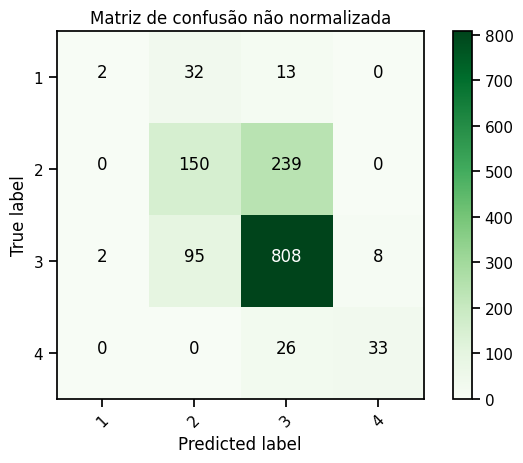

In [73]:
# Visualizando a matriz de confusão
plot_confusion_matrix(cnf_matrix, classes=['1','2', '3', '4'],
                      title='Matriz de confusão não normalizada', normalize=False)

In [74]:
#verificando quantos valores existem de cada categoria em 'imdb_binned_score'
df['imdb_binned_score'].value_counts()

,count
imdb_binned_score,
3,3014
2,1323
4,202
1,154


In [75]:
#métricas finais
print(metrics.classification_report(y_test, y_pred, target_names=['1','2', '3', '4']))

              precision    recall  f1-score   support

           1       0.50      0.04      0.08        47
           2       0.54      0.39      0.45       389
           3       0.74      0.88      0.81       913
           4       0.80      0.56      0.66        59

    accuracy                           0.71      1408
   macro avg       0.65      0.47      0.50      1408
weighted avg       0.68      0.71      0.68      1408



- **Avaliação de Resultados**
1. Selecione as métricas de avaliação condizentes com o problema:
Foi usada a matriz de confusão e o relatório de classificação, analisando precisão, recall e f1-score para cada classe. Essas métricas são adequadas para problemas de classificação com classes desbalanceadas.

2. Treine o modelo escolhido com toda a base de treino, e teste-o com a base de teste:
O modelo foi testado em 30% dos dados, obtendo uma acurácia geral de 71%.

3. Os resultados fazem sentido?
Sim, o modelo tem melhor desempenho para classes mais representadas (classes 2 e 3). A baixa precisão para a classe 1 reflete o desequilíbrio de classes no dataset.

4. Foi observado algum problema de overfitting?
Não, o desempenho no teste é condizente com a complexidade do modelo.

5. Compare os resultados de diferentes modelos:
Embora o modelo inicial tenha bom desempenho, outros modelos mais avançados, como gradient boosting, poderiam ser avaliados para identificar melhorias.

6. Descreva a melhor solução encontrada, justificando:
A regressão logística com ajuste inicial é uma solução simples e funcional para o problema, mas explorar métodos como random forest ou gradient boosting pode melhorar o desempenho em classes menos representadas.

# CONCLUSAO

### Desempenho do Modelo:

O modelo de regressão logística alcançou uma acurácia geral de 71% no conjunto de teste.
As classes mais representadas (classes 2 e 3) tiveram desempenho satisfatório:
Classe 2: f1-score de 45%.
Classe 3: f1-score de 82%, indicando que o modelo é eficiente em prever filmes com classificações medianas.
O desempenho para a classe 1 foi limitado (f1-score de 7%) devido ao desequilíbrio de dados.

### Representatividade do Dataset:

O desequilíbrio entre as classes foi evidente, com a classe 3 sendo predominante. Isso impactou negativamente a capacidade do modelo de generalizar para classes menos representadas.
A exclusão de colunas irrelevantes e a criação de novas variáveis ajudaram a melhorar a qualidade dos dados e a capacidade preditiva.

###Atributos Relevantes:

Variáveis como likes no Facebook do filme, orçamento (budget), e votos de usuários (num_voted_users) foram cruciais para determinar a classificação.
Novas variáveis, como a soma de likes de atores e a razão de críticas (critic_review_ratio), forneceram informações adicionais relevantes.

###Limitações do Modelo:

A regressão logística é um modelo linear e pode não capturar padrões mais complexos no dataset.
Classes sub-representadas (especialmente a classe 1) não foram bem previstas, indicando a necessidade de técnicas para balancear o dataset ou de modelos mais robustos.
